In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import argparse
import noise
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import MotionClouds as mc
from torchvision import datasets, transforms
from torch.autograd import Variable
from LogGabor import LogGabor

## Charger la matrice de certitude

In [2]:
path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    print('Loading accuracy...')
    accuracy =  np.load(path)
    print(accuracy)
else:
    print('No accuracy data found.')

Loading accuracy...
[[0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 ...
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]]


## Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [3]:
def vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y, rho):
    phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
              'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    phase = np.pi/4
    edge = lg.normalize(lg.invert(lg.loggabor(
        N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_orient in range(N_orient):
            for i_scale in range(N_scale):
                ecc = (1/rho)**(N_scale - i_scale)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * \
                    np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                y = N_Y/2 + r * \
                    np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': lg.pe.B_sf,
                              'theta': i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                    phase = i_phase * np.pi/2
                    phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()
    return phi


N_theta, N_orient, N_scale, N_phase, N_X, N_Y, rho = 6, 12, 5, 2, 128, 128, 1.95
phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y, rho)
phi_vector = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
phi_plus = np.linalg.pinv(phi_vector)

energy = (phi**2).sum(axis=(0, 3))
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_orient*N_scale, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)


def accuracy_128(i_offset, j_offset, N_pic=128, N_stim=55):
    center = (N_pic-N_stim)//2

    accuracy_128 = 0.1 * np.ones((N_pic, N_pic))
    accuracy_128[int(center+i_offset):int(center+N_stim+i_offset),
                 int(center+j_offset):int(center+N_stim+j_offset)] = accuracy

    accuracy_LP = energy_vector @ np.ravel(accuracy_128)
    return accuracy_LP


def mnist_128(data, i_offset, j_offset, N_pic=128, N_stim=28, noise=True, noise_type='MotionCloud'):
    center = (N_pic-N_stim)//2

    #data_128 = np.zeros((N_pic, N_pic))
    data_128 = (data.min().numpy()) * np.ones((N_pic, N_pic))

    data_128[int(center+i_offset):int(center+N_stim+i_offset),
             int(center+j_offset):int(center+N_stim+j_offset)] = data

    if noise:
        if noise_type == 'MotionCloud':
            data_LP = phi_vector @ np.ravel(data_128 + MotionCloudNoise())
        elif noise_type == 'Perlin':
            data_LP = phi_vector @ np.ravel(
                data_128 + randomized_perlin_noise())
    else:
        data_LP = phi_vector @ np.ravel(data_128)
    return data_LP


def couples(data, i_offset, j_offset):
    v = mnist_128(data, i_offset, j_offset)
    a = accuracy_128(i_offset, j_offset)
    return (v, a)


def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return value


def sigmoid(values):
    values = 1 / (1 + ((1 / 0.1) - 1) * np.exp(-values))
    return values


def randomized_perlin_noise(shape=(128, 128), scale=10, octaves=6, persistence=0.5, lacunarity=2.0, base=0):
    noise_vector = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noise_vector[i][j] = noise.pnoise2(i/scale,
                                               j/scale,
                                               octaves=int(
                                                   octave * abs(np.random.randn()))+1,
                                               persistence=persistence *
                                               abs(np.random.randn()),
                                               lacunarity=lacunarity *
                                               abs(np.random.randn()),
                                               repeatx=shape[0],
                                               repeaty=shape[1],
                                               base=base)
    return noise_vector


def MotionCloudNoise(sf_0=0.125, B_sf=3.):
    mc.N_X, mc.N_Y, mc.N_frame = 128, 128, 1
    fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
    name = 'static'
    env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=B_sf,
                            B_theta=np.inf, V_X=0., V_Y=0., B_V=0, alpha=.5)

    z = mc.rectif(mc.random_cloud(env))
    z = z.reshape((mc.N_X, mc.N_Y))
    return z

## Réseau de neurones

In [4]:
sample_size = 100  # quantity of examples that'll be processed

data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data',
                   train=True,  # def the dataset as training data
                   download=True,  # download if dataset not present on disk
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=sample_size,
    shuffle=True)


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.predict = torch.nn.Linear(n_hidden2, n_output)

    def forward(self, data):
        data = F.relu(self.hidden1(data))
        data = self.hidden2(data)
        data = self.predict(data)
        data = F.sigmoid(data)
        return data


net = Net(n_feature=720, n_hidden1=585, n_hidden2=195, n_output=60)
optimizer = torch.optim.SGD(net.parameters(), lr=0.3)
loss_func = torch.nn.MSELoss()
#loss_func = torch.nn.CrossEntropyLoss()


def train(sample_size, vsize=720, asize=60):
    t_start = time.time()
    print('Starting training...')
    for batch_idx, (data, label) in enumerate(data_loader):
        data_v, data_a = np.zeros((sample_size, 1, vsize)), np.zeros(
            (sample_size, 1, asize))
        for idx in range(sample_size):
            i_offset, j_offset = int(
                minmax(np.random.randn()*5, 35)), int(minmax(np.random.randn()*5, 35))
            data_v[idx, 0, :], data_a[idx, 0, :] = couples(
                data[idx, 0, :], i_offset, j_offset)

        data_v, data_a = Variable(torch.FloatTensor(
            data_v)), Variable(torch.FloatTensor(data_a))

        prediction = net(data_v)
        loss = loss_func(prediction, data_a)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Epoch {}: [{}/{}] Loss: {} Time: {:.2f} mn'.format(
                epoch, batch_idx*sample_size, len(data_loader.dataset),
                loss.data.numpy(), (time.time()-t_start)/60))


def eval_sacc(vsize=720, asize=60, N_pic=128, sacc_lim=5, fovea_size=10, fig_type='cmap'):
    for batch_idx, (data, label) in enumerate(data_loader):
        i_offset, j_offset = int(
            minmax(np.random.randn()*10, 35)), int(minmax(np.random.randn()*10, 35))
        print('Stimulus position: ({},{})'.format(i_offset, j_offset))
        target_in_fovea = False
        sacc_count = 0

        while not target_in_fovea:
            data_v, data_a = np.zeros((1, 1, vsize)), np.zeros((1, 1, asize))
            data_v[0, 0, :], data_a[0, 0, :] = couples(
                data[0, 0, :], i_offset, j_offset)
            data_v, data_a = Variable(torch.FloatTensor(
                data_v)), Variable(torch.FloatTensor(data_a))

            prediction = net(data_v)
            pred_data = prediction.data.numpy()[-1][-1]

            if fig_type == 'cmap':
                image = sigmoid(energy_plus @ pred_data)
                image_reshaped = image.reshape(N_pic, N_pic)

                fig, ax = plt.subplots(figsize=(13, 10.725))
                cmap = ax.pcolor(np.arange(-(N_pic/2), (N_pic/2)),
                                 np.arange(-(N_pic/2), (N_pic/2)), image_reshaped)
                fig.colorbar(cmap)
                plt.axvline(j_offset, c='k')
                plt.axhline(i_offset, c='k')

                for i_pred in range(0, N_pic):
                    for j_pred in range(0, N_pic):
                        if image_reshaped[i_pred][j_pred] == image_reshaped.max():
                            i_hat, j_hat = i_pred-(N_pic/2), j_pred-(N_pic/2)
                            print('Position prediction: ({},{})'.format(
                                i_hat, j_hat))
                            if fig_type == 'cmap':
                                plt.axvline(j_hat, c='r')
                                plt.axhline(i_hat, c='r')
                            break

                # check if the image position is predicted within the fovea
                if i_hat <= (fovea_size/2) and j_hat <= (fovea_size/2):
                    if i_hat >= -(fovea_size/2) and j_hat >= -(fovea_size/2):
                        target_in_fovea = True
                        print(
                            'Target predicted in fovea, stopping the saccadic exploration')

                # check if number of saccades is beyond threshold
                if sacc_count == sacc_lim:
                    print('Stimulus position not found, break')
                    break

                # saccades
                i_offset, j_offset = (i_offset - i_hat), (j_offset - j_hat)
                sacc_count += 1
                print('Stimulus position after saccade: ({}, {})'.format(
                    i_offset, j_offset))

            if fig_type == 'log':
                code = energy_plus @ np.ravel(pred_data)
                code = phi @ code
                global_energy = (code**2).sum(axis=(0, -1))

                log_r_target = 1 + \
                    np.log(np.sqrt(i_offset**2 + j_offset**2) /
                           np.sqrt(N_X**2 + N_Y**2) / 2) / 5
                if j_offset != 0:
                    theta_target = np.arctan(-i_offset / j_offset)
                else:
                    theta_target = np.sign(-i_offset) * np.pi/2
                print('Target position (log_r, theta) = ({},{})'.format(
                    log_r_target, theta_target))
                log_r, theta = np.meshgrid(np.linspace(
                    0, 1, N_scale+1), np.linspace(-np.pi*.625, np.pi*1.375, N_orient+1))

                fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
                ax.pcolor(theta, log_r, np.fliplr(global_energy))
                ax.plot(theta_target, log_r_target, 'r+')

                for n_orient in range(N_orient):
                    for n_scale in range(N_scale):
                        if global_energy[n_orient][n_scale] == np.max(global_energy):
                            print('Position prediction (orient, scale) = ({},{})'.format(
                                n_orient, n_scale))

                target_in_fovea = True

        print('*' * 50)
        return prediction

### Lancer l'apprentissage ou charger les données

In [5]:
path = 'regression_couples_noised.pt'

In [6]:
!ls -l {path}
#!rm {path}

-rw-r--r--  1 laurentperrinet  staff  2192316 May 23 14:51 regression_couples_noised.pt


In [7]:
if os.path.isfile(path):
    net.load_state_dict(torch.load(path))
    print('Loading file', path)
else:
    print('Training model...')
    N_epochs = 10
    for epoch in range(N_epochs):                 #max number of training epochs
        train(sample_size)                 #starting the learning
        torch.save(net.state_dict(), path) #save the neural network state
        print('Model saved at', path)

Loading file regression_couples_noised.pt


### Lancer l'évaluation

Stimulus position: (13,-11)
Position prediction: (1.0,6.0)
Stimulus position after saccade: (12.0, -17.0)


TypeError: slice indices must be integers or None or have an __index__ method

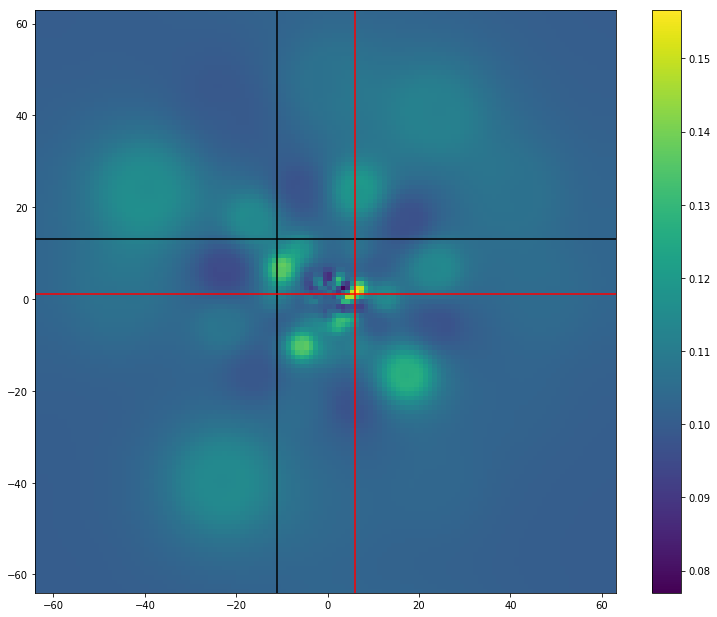

In [8]:
for _ in range(1):
    eval_sacc()

In [ ]:
for _ in range(1):
    eval_sacc(fig_type='log')